In [126]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import newaxis
from sklearn.preprocessing import StandardScaler
from load_gsw import * 

n_maturities = 120
K = 5
# rx_maturities = (6, 18, 24, 36, 48, 60, 84, 120)
rx_maturities = list(range(2,12)) + list(range(12,24,2)) + \
            list(range(24,60,6)) + list(range(60,121,12))

def vec(x):
    return np.reshape(x, (-1, 1))

def vec_quad_form(x):
    return vec(np.outer(x, x))

In [127]:
# Load data
rawYields, plot_dates = load_gsw('data/gsw_ns_params.xlsx', n_maturities)
t = rawYields.shape[0] - 1  # Number of observations

# Compute log excess returns from continuously compounded yields
ttm = np.arange(1.0, n_maturities + 1.0)[newaxis, :] / 12.0
logPrices = -rawYields * ttm
rf = -logPrices[:-1, [0]]
rx = logPrices[1:, :-1] - logPrices[:-1, 1:] - rf

In [128]:
# Extract principal components
scaledYields = StandardScaler(with_std=True).fit_transform(rawYields)
scaledYieldCov = np.cov(scaledYields.T)
[eigenvalues, eigenvectors] = np.linalg.eig(scaledYieldCov)
yieldPCs = StandardScaler().fit_transform(scaledYields @ np.real(eigenvectors))
X = yieldPCs[:, 0:K].T

In [129]:
# Step (1) of the three-step procedure: estimate VAR(1) for the time series of pricing factors.

X_lhs = X[:, 1:]  #X_t+1. Left hand side of VAR.
X_rhs = np.vstack((np.ones((1, t)), X[:, 0:-1])) #X_t and a constant.
var_coeffs = (X_lhs @ np.linalg.pinv(X_rhs))
mu = var_coeffs[:, [0]]
phi = var_coeffs[:, 1:]

v = X_lhs - var_coeffs @ X_rhs
Sigma = v @ v.T / t

In [130]:
# Step (2) of the three-step procedure: regress log excess returns on the factors.
selected_rx = rx[:, [x - 2 for x in rx_maturities]].T  # Offset by 2 since index 0 is excess return on a 2m bond
N = selected_rx.shape[0]
Z = np.vstack((np.ones((1, t)), v, X[:, 0:-1]))  #Innovations and lagged X
abc = selected_rx @ np.linalg.pinv(Z)
E = selected_rx - abc @ Z
sigmasq_ret = np.sum(E * E) / E.size

a = abc[:, [0]]
beta = abc[:, 1:K+1].T
c = abc[:, K+1:]

In [131]:
# Step (3) of the three-step procedure: Run cross-sectional regressions
BStar = np.squeeze(np.apply_along_axis(vec_quad_form, 1, beta.T))
lambda1 = np.linalg.pinv(beta.T) @ c
lambda0 = np.linalg.pinv(beta.T) @ (a + 1/2 * (BStar @ vec(Sigma) + sigmasq_ret))

In [132]:
# Run bond pricing recursions
A = np.zeros((1, n_maturities))
B = np.zeros((K, n_maturities))

delta = rf.T @ np.linalg.pinv(np.vstack((np.ones((1, t)), X[:, 0:-1])))
delta0 = delta[[0], [0]]
delta1 = delta[[0], 1:]

A[0, 0] = -delta0
B[:, 0] = -delta1

for i in range(0, n_maturities - 1):
    A[0, i+1] = A[0, i] + B[:, i].T @ (mu - lambda0) + 1/2 * (B[:, i].T @ Sigma @ B[:, i] + sigmasq_ret) - delta0
    B[:, i+1] = B[:, i] @ (phi - lambda1) - delta1

In [133]:
B.T @ X

array([[ -0.42397741,  -0.4383008 ,  -0.41588876, ...,   0.12177947,
          0.10752775,   0.11182709],
       [ -0.8406617 ,  -0.8690375 ,  -0.83421297, ...,   0.24173383,
          0.21390922,   0.2195048 ],
       [ -1.25057177,  -1.29413997,  -1.2534808 , ...,   0.36154161,
          0.32089175,   0.32518833],
       ...,
       [-30.58239969, -34.96593189, -35.98601305, ...,  23.12281196,
         23.28827683,  21.0852728 ],
       [-30.75751481, -35.17646838, -36.20386771, ...,  23.36776966,
         23.54320139,  21.32477848],
       [-30.93195186, -35.38632898, -36.42105481, ...,  23.61276521,
         23.7982201 ,  21.56440066]])

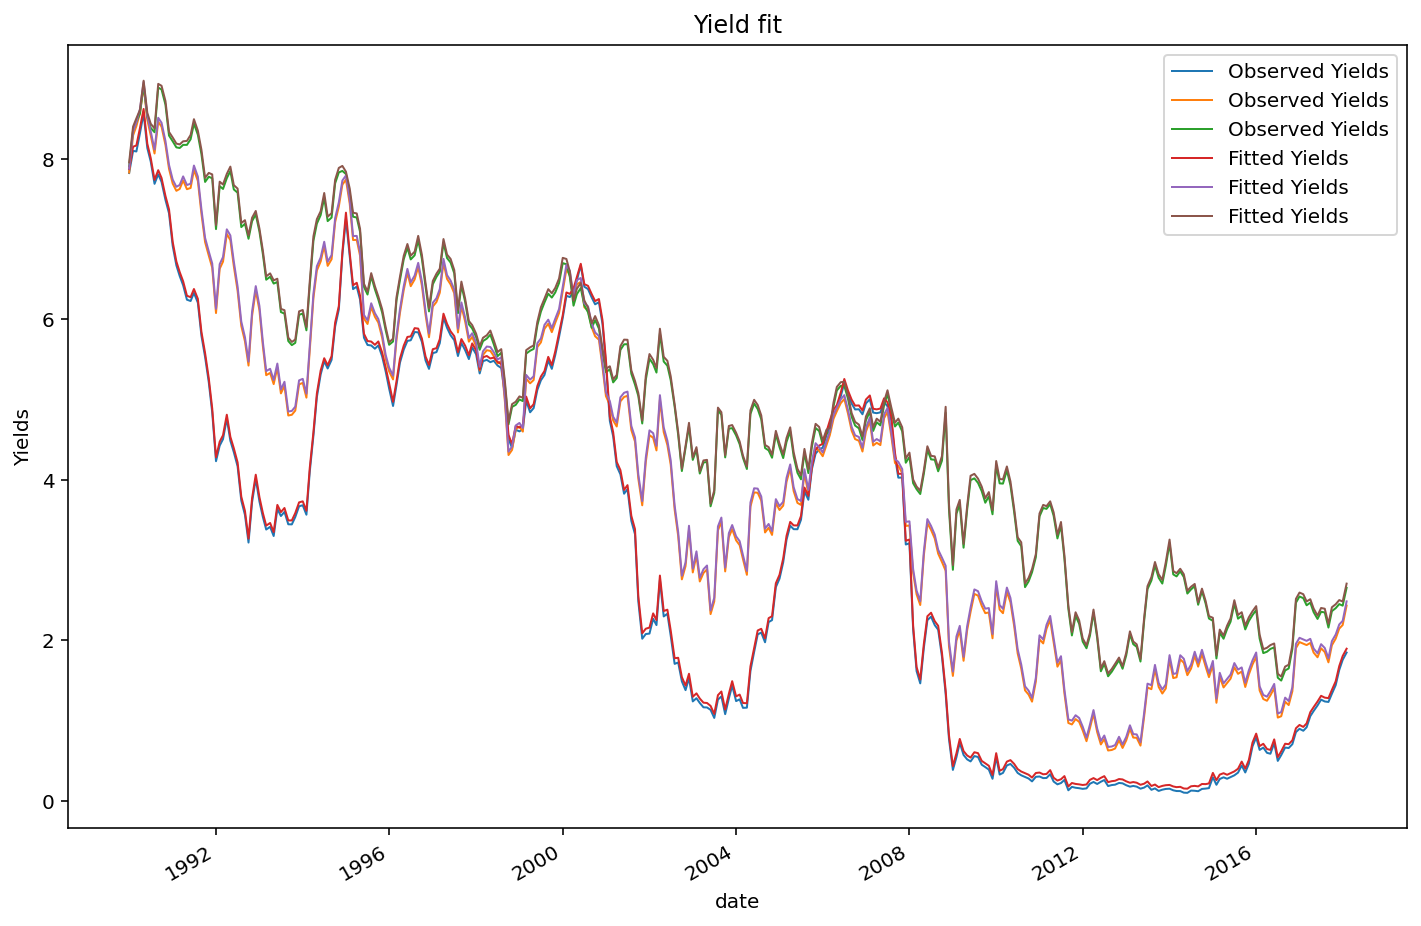

In [134]:
# Construct fitted yields
fittedLogPrices = (A.T + B.T @ X).T
fittedYields = - fittedLogPrices / ttm

# Plot fit for 1y, 5y, 10y bonds
fig, axes = plt.subplots(dpi=144, figsize=(12, 8))
axes.plot(plot_dates, rawYields[:, (11, 59, 119)], label="Observed Yields", linewidth=1)
axes.plot(plot_dates, fittedYields[:, (11, 59, 119)], label = "Fitted Yields", linewidth=1)
axes.xaxis.set_major_locator(mdates.AutoDateLocator())
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
axes.set_xlabel("date")
axes.set_ylabel("Yields")
axes.set_title("Yield fit")
axes.legend()
plt.show()

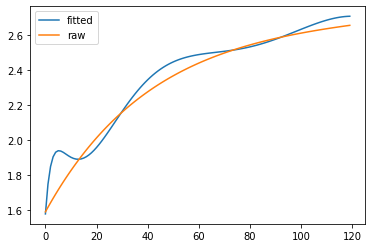

In [135]:
plt.plot(fittedYields[-1:].T, label='fitted')
plt.plot(rawYields[-1:].T, label='raw')
plt.legend()

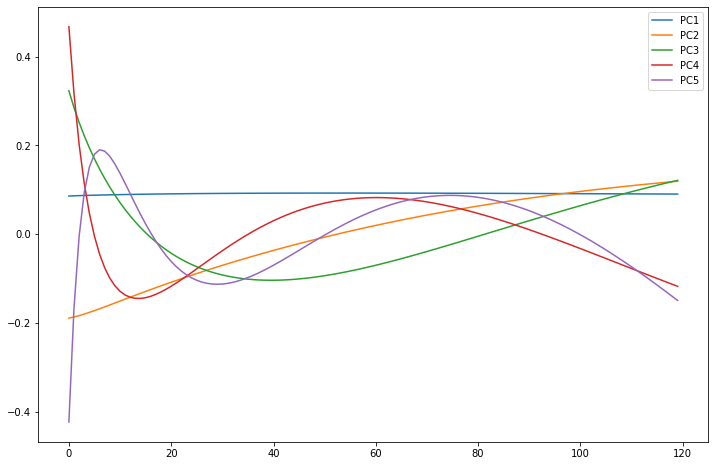

In [136]:
plt.figure(figsize=(12,8))
plt.plot(np.real(eigenvectors[:, :K]), label=[f'PC{k}' for k in range(1, K+1)])
plt.legend()
plt.show()